# University of Aberdeen

## Applied AI (CS5079)

### Tutorial (Day 3) - Reinforcement Learning with OpenAI Gym

---

The practical is inspired from the code on: https://github.com/ageron/handson-ml/blob/master/16_reinforcement_learning.ipynb


## Learning Outcomes

On successful completion of this component a student will have demonstrated competence in creating and training an agent to play an Atari game using the screen frames as input

### In this tutorial, we will use the following libraries and modules

In [ ]:
!pip install git+https://github.com/openai/baselines.git


In [1]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)

# Import the Keras backend used for freeing the global state
# to avoid clutter
from tensorflow.keras import backend as K

# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack
from tensorflow import keras
from tensorflow.keras import layers

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym
FRAME_STACK_SIZE = 3
env = gym.make("Asterix-v0")
env = NoopResetEnv(env, noop_max=30)
env = wrap_deepmind(env, frame_stack=False, scale=False, clip_rewards=False, episode_life=False)
env = FrameStack(env, FRAME_STACK_SIZE)
env.seed(SEED_VALUE)
# I have installed pyglet-1.5.11 for it work with BigSur

c:\program files\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\program files\python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


[1337, 17452119]

## Atari Games

In this tutorial, we will create an agent to play the Boxing Atari game. In this game, two boxers, one white and one black, compete against each other. When close enough, a boxer can hit his opponent with a punch which causes his opponent to reel back slightly. A match is completed either when one player lands 100 punches or two minutes have elapsed. In the case of a decision, the player with the most landed punches is the winner. Ties are possible. 

![Activision's Boxing Cartridge](img/Boxing.png)

In this tutorial, we will use the pixels as inputs. The OpenAI Gym environment is `Boxing-v0`. 

### Naive Agent
1.1. For the boxing game, describe the observations, the action space, the reward, the environment’s info dictionary and the episode.


In [2]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())

Observation space: Box(84, 84, 3)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


The observation space is an RGB picture of size 210x160 whereas the action space is composed of the 18 possible moves from an ATARI controller. The info dictionary contains `ale.lives()` which refers to the number of lives left (but here there is no finite number of lives).

1.2. Create a simple agent that performs random actions.

### Deep Q-Learning Agent

1.3. Implement a pre-processing function to convert the $210\times160$ RGB frames to $96\times80$ greyscale frames. Then, change the type of the matrix to `int8`.


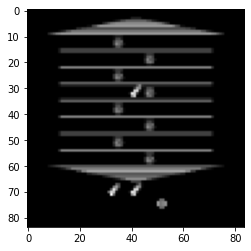

In [3]:
obs = env.reset()
from skimage.color import rgb2gray

# def preprocess_observation(observation):
#     img = observation[23:153:2, ::2] # This becomes 90, 80, 3
# #     print(img.shape)
# #     print(img.shape)
# #     img = img.mean(axis=2) #to grayscale (values between 0 and 255)
#     img = rgb2gray(img)
#     img = img.astype(np.float32) # normalize from -128 to 127
#     return img.reshape(65, 80)


plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

1.4. Create a function `q_network` that (1) takes as input a variable of shape $(96,80,1)$, (2) creates a deep convolutional network with 3 convolutional hidden layers and two dense layers, and (3) returns the output layer and the trainable variables in a dictionary where the keys are the name of the variables.

In [4]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    # Release the global state to avoid clutter
    # when creating models (in loops etc.)
#     K.clear_session()
    
    # Reset the Tensorflow graph
#     tf.compat.v1.reset_default_graph()
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

In [5]:
# Import the Keras layer used for building our models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

INPUT_SHAPE = env.observation_space.shape
NUM_ACTIONS = env.action_space.n
BATCH_SIZE = 32
MEMORY_SIZE = 25000
EXPLORATION_STEPS = 20000
LEARNING_RATE = 0.00025

1.5. Create an agent `QLearningAgent` with two deep convolutional networks (`online` and `target`) to predict the action to be taken from the game's frames. The `online` network will be trained and replace the `target`network every $5000$ training steps.


1.6. Create a method `get_action` using a parameter $\epsilon$ for making random moves. This parameter will decrease from $1$ to $0.1$.

1.7. Create a method `train` to update the weights of the `online` network using the Q-values of the `target` network. We will use a discount rate of $0.99$. 

In [6]:
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [7]:
#-------------------- MEMORY --------------------------
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [8]:
from collections import deque
import math

MAX_EPSILON = 1
MIN_EPSILON = 0.1
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS  # speed of decay

class QLearningAgent():
    steps = 0
    
    def __init__(self, env, lr=LEARNING_RATE):
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        self.loss_val = np.inf
        self.action_size = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99
        self.checkpoint_path = "./my_dqn.ckpt"

        # Create the two networks for predicting the actions
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 5000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64, units=256):
        """Define and return the CNN model architecture
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_size)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_size)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        
        no_state = np.zeros(INPUT_SHAPE)
        
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
    
        prev_q_vals = self.online.predict(prev_states)
        
        next_q_vals_double = self.online.predict(next_states)
        next_q_vals = self.target.predict(next_states)
        
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value
            future_q_val = q_val
            
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            X[idx] = curr_state
            Y[idx] = future_q_val
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value
        """
        
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        if step <= EXPLORATION_STEPS:
            return
        
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


1.8. Train your network for $1,000,000$ training steps. Since the training process can take __a lot of time__, save your models every $1000$ training steps. You can choose to only train your model every $4$ frames instead of every frames.

In [ ]:
import time
agent = QLearningAgent(env)  
ep_rewards = []
ep_steps = []
total_reward = 0
n_steps = 1000000  # total number of training steps
save_steps = 50


# Train the model after 4 actions
train_online_steps = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
update_target_steps = 10000

done=True
for step in range(n_steps):
    total_perc = step * 100 / n_steps
    print(f"\r\tAction step: {step}/{n_steps} ({total_perc:.2f}%)\tLoss: {agent.loss_val:5f}", end="")
    if done: # game over, start again
        avg_reward = int(total_reward/3)
        if total_reward:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        state = np.array(env.reset())
        total_reward = 0
#         state = preprocess_observation(obs)


    # Get a exploration/exploitation action depending on the
    # current epsilon value
#     q_values = agent.online.predict(state)
    action = agent.get_action(state, step)

    # Online DQN plays
    next_state, reward, done, info = env.step(action)

    next_state = np.array(next_state)
    
#     next_state = preprocess_observation(next_obs)
    agent.save_to_memory(state, action, reward, next_state, done, step)
    
    if step > EXPLORATION_STEPS:
        if step % train_online_steps == 0:
            agent.train(step)

        # Regularly copy the online DQN to the target DQN
        if step % update_target_steps == 0:
            agent.update_target()
    
    env.render()
    total_reward += reward
    state = next_state
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan


c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 278/1000000 (0.03%)	Loss:   inf	AVG reward: 33	Total mean: 100.0
	Action step: 629/1000000 (0.06%)	Loss:   inf	AVG reward: 100	Total mean: 200.0
	Action step: 921/1000000 (0.09%)	Loss:   inf	AVG reward: 116	Total mean: 250.0
	Action step: 1513/1000000 (0.15%)	Loss:   inf	AVG reward: 200	Total mean: 337.5
	Action step: 1821/1000000 (0.18%)	Loss:   inf	AVG reward: 66	Total mean: 310.0
	Action step: 2427/1000000 (0.24%)	Loss:   inf	AVG reward: 283	Total mean: 400.0
	Action step: 2707/1000000 (0.27%)	Loss:   inf	AVG reward: 33	Total mean: 357.14285714285717
	Action step: 3154/1000000 (0.32%)	Loss:   inf	AVG reward: 100	Total mean: 350.0
	Action step: 3424/1000000 (0.34%)	Loss:   inf	AVG reward: 33	Total mean: 322.22222222222223
	Action step: 3774/1000000 (0.38%)	Loss:   inf	AVG reward: 116	Total mean: 325.0
	Action step: 4092/1000000 (0.41%)	Loss:   inf	AVG reward: 66	Total mean: 313.6363636363636
	Action step: 4600/1000000 (0.46%)	Loss:   inf	AVG reward: 150	Total mean: 325.

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20107/1000000 (2.01%)	Loss: 2.862436	AVG reward: 50	Total mean: 267.2413793103448
	Action step: 20545/1000000 (2.05%)	Loss: 5.777563	AVG reward: 150	Total mean: 270.33898305084745
	Action step: 20869/1000000 (2.09%)	Loss: 2.765413	AVG reward: 66	Total mean: 269.1666666666667
	Action step: 21186/1000000 (2.12%)	Loss: 2.730621	AVG reward: 150	Total mean: 272.1311475409836
	Action step: 21547/1000000 (2.15%)	Loss: 2.758572	AVG reward: 33	Total mean: 269.35483870967744
	Action step: 21860/1000000 (2.19%)	Loss: 2.473868	AVG reward: 50	Total mean: 267.46031746031747
	Action step: 22224/1000000 (2.22%)	Loss: 3.012512	AVG reward: 116	Total mean: 268.75
	Action step: 22531/1000000 (2.25%)	Loss: 3.482530	AVG reward: 66	Total mean: 267.6923076923077
	Action step: 22947/1000000 (2.29%)	Loss: 3.344577	AVG reward: 83	Total mean: 267.42424242424244
	Action step: 23222/1000000 (2.32%)	Loss: 3.986826	AVG reward: 33	Total mean: 264.92537313432837
	Action step: 23480/1000000 (2.35%)	Loss: 4

	Action step: 51313/1000000 (5.13%)	Loss: 0.105276	AVG reward: 116	Total mean: 268.43971631205676
	Action step: 51737/1000000 (5.17%)	Loss: 0.280348	AVG reward: 133	Total mean: 269.36619718309856
	Action step: 52046/1000000 (5.20%)	Loss: 0.200740	AVG reward: 66	Total mean: 268.8811188811189
	Action step: 52311/1000000 (5.23%)	Loss: 0.491384	AVG reward: 50	Total mean: 268.05555555555554
	Action step: 52573/1000000 (5.26%)	Loss: 0.191713	AVG reward: 66	Total mean: 267.58620689655174
	Action step: 52954/1000000 (5.30%)	Loss: 0.573318	AVG reward: 133	Total mean: 268.4931506849315
	Action step: 53231/1000000 (5.32%)	Loss: 0.169589	AVG reward: 66	Total mean: 268.02721088435374
	Action step: 53698/1000000 (5.37%)	Loss: 0.206508	AVG reward: 150	Total mean: 269.2567567567568
	Action step: 54198/1000000 (5.42%)	Loss: 0.211957	AVG reward: 133	Total mean: 270.13422818791946
	Action step: 54466/1000000 (5.45%)	Loss: 0.652993	AVG reward: 66	Total mean: 269.6666666666667
	Action step: 54744/1000000 (

	Action step: 79219/1000000 (7.92%)	Loss: 0.150528	AVG reward: 116	Total mean: 267.1111111111111
	Action step: 79512/1000000 (7.95%)	Loss: 0.495363	AVG reward: 50	Total mean: 266.5929203539823
	Action step: 80178/1000000 (8.02%)	Loss: 0.670574	AVG reward: 150	Total mean: 267.40088105726875
	Action step: 80569/1000000 (8.06%)	Loss: 0.677582	AVG reward: 116	Total mean: 267.7631578947368
	Action step: 80836/1000000 (8.08%)	Loss: 0.508121	AVG reward: 66	Total mean: 267.46724890829694
	Action step: 81264/1000000 (8.13%)	Loss: 0.466505	AVG reward: 83	Total mean: 267.39130434782606
	Action step: 81527/1000000 (8.15%)	Loss: 0.337826	AVG reward: 50	Total mean: 266.8831168831169
	Action step: 81762/1000000 (8.18%)	Loss: 0.326207	AVG reward: 16	Total mean: 265.94827586206895
	Action step: 82090/1000000 (8.21%)	Loss: 0.757126	AVG reward: 50	Total mean: 265.45064377682405
	Action step: 82575/1000000 (8.26%)	Loss: 0.485343	AVG reward: 166	Total mean: 266.45299145299145
	Action step: 83151/1000000 (8

	Action step: 112132/1000000 (11.21%)	Loss: 0.479752	AVG reward: 16	Total mean: 272.168284789644
	Action step: 112468/1000000 (11.25%)	Loss: 0.650980	AVG reward: 66	Total mean: 271.93548387096774
	Action step: 112850/1000000 (11.29%)	Loss: 0.269115	AVG reward: 66	Total mean: 271.7041800643087
	Action step: 113125/1000000 (11.31%)	Loss: 0.480644	AVG reward: 66	Total mean: 271.47435897435895
	Action step: 113685/1000000 (11.37%)	Loss: 0.539565	AVG reward: 133	Total mean: 271.8849840255591
	Action step: 113986/1000000 (11.40%)	Loss: 0.556040	AVG reward: 100	Total mean: 271.97452229299364
	Action step: 114256/1000000 (11.43%)	Loss: 0.215998	AVG reward: 16	Total mean: 271.26984126984127
	Action step: 114526/1000000 (11.45%)	Loss: 0.466295	AVG reward: 50	Total mean: 270.88607594936707
	Action step: 114924/1000000 (11.49%)	Loss: 0.399574	AVG reward: 83	Total mean: 270.82018927444796
	Action step: 115191/1000000 (11.52%)	Loss: 0.382485	AVG reward: 83	Total mean: 270.75471698113205
	Action step

	Action step: 141594/1000000 (14.16%)	Loss: 0.297487	AVG reward: 33	Total mean: 266.1125319693095
	Action step: 141870/1000000 (14.19%)	Loss: 0.379509	AVG reward: 50	Total mean: 265.81632653061223
	Action step: 142217/1000000 (14.22%)	Loss: 0.679378	AVG reward: 50	Total mean: 265.52162849872775
	Action step: 142589/1000000 (14.26%)	Loss: 0.740666	AVG reward: 133	Total mean: 265.8629441624365
	Action step: 142843/1000000 (14.28%)	Loss: 0.480457	AVG reward: 33	Total mean: 265.44303797468353
	Action step: 143124/1000000 (14.31%)	Loss: 0.287333	AVG reward: 33	Total mean: 265.02525252525254
	Action step: 143432/1000000 (14.34%)	Loss: 0.409224	AVG reward: 50	Total mean: 264.735516372796
	Action step: 143980/1000000 (14.40%)	Loss: 0.587614	AVG reward: 116	Total mean: 264.9497487437186
	Action step: 144411/1000000 (14.44%)	Loss: 0.461102	AVG reward: 150	Total mean: 265.4135338345865
	Action step: 144773/1000000 (14.48%)	Loss: 0.301505	AVG reward: 116	Total mean: 265.625
	Action step: 145060/10

	Action step: 169170/1000000 (16.92%)	Loss: 0.558570	AVG reward: 83	Total mean: 259.61945031712474
	Action step: 169457/1000000 (16.95%)	Loss: 0.258763	AVG reward: 50	Total mean: 259.38818565400845
	Action step: 169869/1000000 (16.99%)	Loss: 0.244776	AVG reward: 100	Total mean: 259.4736842105263
	Action step: 170258/1000000 (17.03%)	Loss: 0.572855	AVG reward: 83	Total mean: 259.453781512605
	Action step: 170525/1000000 (17.05%)	Loss: 0.367440	AVG reward: 33	Total mean: 259.1194968553459
	Action step: 170800/1000000 (17.08%)	Loss: 0.506293	AVG reward: 33	Total mean: 258.78661087866107
	Action step: 171074/1000000 (17.11%)	Loss: 0.309050	AVG reward: 83	Total mean: 258.76826722338205
	Action step: 171352/1000000 (17.14%)	Loss: 0.586074	AVG reward: 66	Total mean: 258.6458333333333
	Action step: 171609/1000000 (17.16%)	Loss: 0.330624	AVG reward: 0	Total mean: 258.6458333333333
	Action step: 171885/1000000 (17.19%)	Loss: 0.334854	AVG reward: 100	Total mean: 258.7318087318087
	Action step: 17

	Action step: 197967/1000000 (19.80%)	Loss: 0.793414	AVG reward: 83	Total mean: 256.7028985507246
	Action step: 198364/1000000 (19.84%)	Loss: 0.200590	AVG reward: 116	Total mean: 256.871609403255
	Action step: 198620/1000000 (19.86%)	Loss: 0.487619	AVG reward: 33	Total mean: 256.5884476534296
	Action step: 198888/1000000 (19.89%)	Loss: 0.729515	AVG reward: 16	Total mean: 256.2162162162162
	Action step: 199145/1000000 (19.91%)	Loss: 0.196061	AVG reward: 50	Total mean: 256.02517985611513
	Action step: 199535/1000000 (19.95%)	Loss: 0.518553	AVG reward: 50	Total mean: 255.83482944344703
	Action step: 199839/1000000 (19.98%)	Loss: 0.659470	AVG reward: 83	Total mean: 255.82437275985663
	Action step: 200586/1000000 (20.06%)	Loss: 0.829790	AVG reward: 150	Total mean: 256.1717352415027
	Action step: 200995/1000000 (20.10%)	Loss: 0.394640	AVG reward: 150	Total mean: 256.51785714285717
	Action step: 201367/1000000 (20.14%)	Loss: 0.724286	AVG reward: 66	Total mean: 256.41711229946526
	Action step:

	Action step: 235470/1000000 (23.55%)	Loss: 0.362934	AVG reward: 66	Total mean: 259.8892405063291
	Action step: 235816/1000000 (23.58%)	Loss: 0.236904	AVG reward: 50	Total mean: 259.7156398104265
	Action step: 236786/1000000 (23.68%)	Loss: 0.513748	AVG reward: 166	Total mean: 260.09463722397476
	Action step: 237062/1000000 (23.71%)	Loss: 0.281430	AVG reward: 50	Total mean: 259.9212598425197
	Action step: 237332/1000000 (23.73%)	Loss: 0.552314	AVG reward: 66	Total mean: 259.82704402515725
	Action step: 237806/1000000 (23.78%)	Loss: 0.232985	AVG reward: 133	Total mean: 260.04709576138146
	Action step: 238225/1000000 (23.82%)	Loss: 1.042696	AVG reward: 100	Total mean: 260.1097178683386
	Action step: 238515/1000000 (23.85%)	Loss: 0.883928	AVG reward: 83	Total mean: 260.09389671361504
	Action step: 238917/1000000 (23.89%)	Loss: 0.587443	AVG reward: 116	Total mean: 260.234375
	Action step: 239186/1000000 (23.92%)	Loss: 0.406824	AVG reward: 66	Total mean: 260.14040561622465
	Action step: 2395

	Action step: 268040/1000000 (26.80%)	Loss: 0.396158	AVG reward: 66	Total mean: 259.90168539325845
	Action step: 268324/1000000 (26.83%)	Loss: 0.571948	AVG reward: 83	Total mean: 259.88779803646565
	Action step: 269354/1000000 (26.94%)	Loss: 0.116800	AVG reward: 250	Total mean: 260.5742296918767
	Action step: 269626/1000000 (26.96%)	Loss: 0.585248	AVG reward: 66	Total mean: 260.4895104895105
	Action step: 269976/1000000 (27.00%)	Loss: 0.876030	AVG reward: 66	Total mean: 260.4050279329609
	Action step: 270257/1000000 (27.03%)	Loss: 0.304118	AVG reward: 33	Total mean: 260.1813110181311
	Action step: 271533/1000000 (27.15%)	Loss: 0.448826	AVG reward: 216	Total mean: 260.7242339832869
	Action step: 272089/1000000 (27.21%)	Loss: 0.526705	AVG reward: 83	Total mean: 260.7093184979138
	Action step: 272865/1000000 (27.29%)	Loss: 0.746969	AVG reward: 200	Total mean: 261.18055555555554
	Action step: 273370/1000000 (27.34%)	Loss: 0.294258	AVG reward: 133	Total mean: 261.373092926491
	Action step: 

	Action step: 301336/1000000 (30.13%)	Loss: 0.537710	AVG reward: 233	Total mean: 259.4816687737042
	Action step: 301622/1000000 (30.16%)	Loss: 0.541494	AVG reward: 33	Total mean: 259.280303030303
	Action step: 301887/1000000 (30.19%)	Loss: 0.609236	AVG reward: 50	Total mean: 259.14249684741486
	Action step: 302291/1000000 (30.23%)	Loss: 0.466628	AVG reward: 66	Total mean: 259.06801007556675
	Action step: 302694/1000000 (30.27%)	Loss: 0.445438	AVG reward: 83	Total mean: 259.0566037735849
	Action step: 302954/1000000 (30.30%)	Loss: 0.368615	AVG reward: 33	Total mean: 258.856783919598
	Action step: 303229/1000000 (30.32%)	Loss: 0.736264	AVG reward: 66	Total mean: 258.78293601003764
	Action step: 304325/1000000 (30.43%)	Loss: 0.403790	AVG reward: 216	Total mean: 259.2731829573935
	Action step: 305026/1000000 (30.50%)	Loss: 0.381155	AVG reward: 133	Total mean: 259.4493116395494
	Action step: 305295/1000000 (30.53%)	Loss: 0.555768	AVG reward: 16	Total mean: 259.1875
	Action step: 305558/1000

	Action step: 335532/1000000 (33.55%)	Loss: 0.216153	AVG reward: 83	Total mean: 257.0852534562212
	Action step: 335808/1000000 (33.58%)	Loss: 0.450158	AVG reward: 100	Total mean: 257.13463751438434
	Action step: 337560/1000000 (33.76%)	Loss: 0.384959	AVG reward: 350	Total mean: 258.04597701149424
	Action step: 337823/1000000 (33.78%)	Loss: 0.287900	AVG reward: 83	Total mean: 258.03673938002294
	Action step: 338177/1000000 (33.82%)	Loss: 0.801901	AVG reward: 83	Total mean: 258.0275229357798
	Action step: 338473/1000000 (33.85%)	Loss: 0.561219	AVG reward: 33	Total mean: 257.8465063001145
	Action step: 338753/1000000 (33.88%)	Loss: 0.438334	AVG reward: 33	Total mean: 257.66590389016017
	Action step: 339020/1000000 (33.90%)	Loss: 0.642685	AVG reward: 50	Total mean: 257.54285714285714
	Action step: 339295/1000000 (33.93%)	Loss: 0.548523	AVG reward: 83	Total mean: 257.5342465753425
	Action step: 339580/1000000 (33.96%)	Loss: 0.528381	AVG reward: 50	Total mean: 257.4116305587229
	Action step:

	Action step: 370418/1000000 (37.04%)	Loss: 0.468605	AVG reward: 133	Total mean: 260.63492063492066
	Action step: 370688/1000000 (37.07%)	Loss: 0.367950	AVG reward: 100	Total mean: 260.67653276955605
	Action step: 371841/1000000 (37.18%)	Loss: 0.712207	AVG reward: 216	Total mean: 261.08764519535373
	Action step: 372220/1000000 (37.22%)	Loss: 0.546867	AVG reward: 116	Total mean: 261.1814345991561
	Action step: 372895/1000000 (37.29%)	Loss: 0.766131	AVG reward: 200	Total mean: 261.53846153846155
	Action step: 373182/1000000 (37.32%)	Loss: 0.811972	AVG reward: 66	Total mean: 261.4736842105263
	Action step: 373738/1000000 (37.37%)	Loss: 0.559187	AVG reward: 66	Total mean: 261.40904311251313
	Action step: 374013/1000000 (37.40%)	Loss: 0.623115	AVG reward: 66	Total mean: 261.34453781512605
	Action step: 374299/1000000 (37.43%)	Loss: 0.823624	AVG reward: 100	Total mean: 261.38509968520464
	Action step: 374589/1000000 (37.46%)	Loss: 0.374513	AVG reward: 83	Total mean: 261.37316561844864
	Actio

	Action step: 405400/1000000 (40.54%)	Loss: 0.528674	AVG reward: 66	Total mean: 263.3170731707317
	Action step: 405865/1000000 (40.59%)	Loss: 0.366171	AVG reward: 116	Total mean: 263.40155945419104
	Action step: 406146/1000000 (40.61%)	Loss: 0.484437	AVG reward: 33	Total mean: 263.24245374878285
	Action step: 406405/1000000 (40.64%)	Loss: 0.443486	AVG reward: 33	Total mean: 263.08365758754866
	Action step: 406822/1000000 (40.68%)	Loss: 0.298461	AVG reward: 83	Total mean: 263.0709426627794
	Action step: 407083/1000000 (40.71%)	Loss: 0.467055	AVG reward: 83	Total mean: 263.05825242718447
	Action step: 407510/1000000 (40.75%)	Loss: 0.254420	AVG reward: 83	Total mean: 263.04558680892336
	Action step: 407816/1000000 (40.78%)	Loss: 0.697583	AVG reward: 116	Total mean: 263.12984496124034
	Action step: 409093/1000000 (40.91%)	Loss: 0.123907	AVG reward: 216	Total mean: 263.50435624394964
	Action step: 409968/1000000 (41.00%)	Loss: 0.548463	AVG reward: 200	Total mean: 263.82978723404256
	Action 

	Action step: 437378/1000000 (43.74%)	Loss: 0.219500	AVG reward: 66	Total mean: 263.0769230769231
	Action step: 437639/1000000 (43.76%)	Loss: 0.565465	AVG reward: 0	Total mean: 263.0769230769231
	Action step: 437897/1000000 (43.79%)	Loss: 0.243339	AVG reward: 66	Total mean: 263.0198915009042
	Action step: 438173/1000000 (43.82%)	Loss: 0.690371	AVG reward: 0	Total mean: 263.0198915009042
	Action step: 438941/1000000 (43.89%)	Loss: 0.644618	AVG reward: 166	Total mean: 263.23396567299005
	Action step: 439189/1000000 (43.92%)	Loss: 0.191847	AVG reward: 16	Total mean: 263.04151624548734
	Action step: 439457/1000000 (43.95%)	Loss: 0.517076	AVG reward: 33	Total mean: 262.89449954914335
	Action step: 439737/1000000 (43.97%)	Loss: 0.192784	AVG reward: 83	Total mean: 262.8828828828829
	Action step: 440453/1000000 (44.05%)	Loss: 1.030442	AVG reward: 183	Total mean: 263.14131413141314
	Action step: 440997/1000000 (44.10%)	Loss: 0.347800	AVG reward: 133	Total mean: 263.2643884892086
	Action step: 4

	Action step: 475422/1000000 (47.54%)	Loss: 0.431000	AVG reward: 100	Total mean: 266.24365482233503
	Action step: 475686/1000000 (47.57%)	Loss: 0.526841	AVG reward: 66	Total mean: 266.18765849535083
	Action step: 475966/1000000 (47.60%)	Loss: 0.765552	AVG reward: 50	Total mean: 266.08952702702703
	Action step: 476464/1000000 (47.65%)	Loss: 0.579913	AVG reward: 150	Total mean: 266.2447257383966
	Action step: 477019/1000000 (47.70%)	Loss: 0.338503	AVG reward: 116	Total mean: 266.31534569983137
	Action step: 477292/1000000 (47.73%)	Loss: 0.244847	AVG reward: 83	Total mean: 266.301600673968
	Action step: 477643/1000000 (47.76%)	Loss: 0.284109	AVG reward: 100	Total mean: 266.32996632996634
	Action step: 478123/1000000 (47.81%)	Loss: 0.124689	AVG reward: 83	Total mean: 266.31623212783853
	Action step: 478387/1000000 (47.84%)	Loss: 0.393465	AVG reward: 33	Total mean: 266.1764705882353
	Action step: 478656/1000000 (47.87%)	Loss: 0.533449	AVG reward: 50	Total mean: 266.0789252728799
	Action ste

	Action step: 512486/1000000 (51.25%)	Loss: 0.569036	AVG reward: 66	Total mean: 269.96830427892235
	Action step: 512762/1000000 (51.28%)	Loss: 0.849360	AVG reward: 33	Total mean: 269.833729216152
	Action step: 513452/1000000 (51.35%)	Loss: 0.863667	AVG reward: 100	Total mean: 269.85759493670884
	Action step: 513806/1000000 (51.38%)	Loss: 0.688918	AVG reward: 133	Total mean: 269.9604743083004
	Action step: 514085/1000000 (51.41%)	Loss: 0.426554	AVG reward: 66	Total mean: 269.90521327014216
	Action step: 514615/1000000 (51.46%)	Loss: 0.393189	AVG reward: 150	Total mean: 270.0473559589582
	Action step: 514886/1000000 (51.49%)	Loss: 0.786339	AVG reward: 50	Total mean: 269.9526813880126
	Action step: 515207/1000000 (51.52%)	Loss: 0.593256	AVG reward: 50	Total mean: 269.8581560283688
	Action step: 515709/1000000 (51.57%)	Loss: 0.526283	AVG reward: 100	Total mean: 269.88188976377955
	Action step: 515978/1000000 (51.60%)	Loss: 1.088114	AVG reward: 16	Total mean: 269.70889063729345
	Action step

	Action step: 558653/1000000 (55.87%)	Loss: 0.236096	AVG reward: 200	Total mean: 274.1263940520446
	Action step: 559207/1000000 (55.92%)	Loss: 0.448216	AVG reward: 166	Total mean: 274.29420505200596
	Action step: 559896/1000000 (55.99%)	Loss: 0.389166	AVG reward: 200	Total mean: 274.536005939124
	Action step: 560573/1000000 (56.06%)	Loss: 0.564802	AVG reward: 183	Total mean: 274.74035608308606
	Action step: 560983/1000000 (56.10%)	Loss: 0.543627	AVG reward: 83	Total mean: 274.72201630837657
	Action step: 561345/1000000 (56.13%)	Loss: 0.605737	AVG reward: 50	Total mean: 274.6296296296296
	Action step: 561592/1000000 (56.16%)	Loss: 0.612853	AVG reward: 33	Total mean: 274.500370096225
	Action step: 562016/1000000 (56.20%)	Loss: 0.720090	AVG reward: 66	Total mean: 274.4452662721894
	Action step: 562509/1000000 (56.25%)	Loss: 0.488128	AVG reward: 116	Total mean: 274.5011086474501
	Action step: 563151/1000000 (56.32%)	Loss: 0.487969	AVG reward: 116	Total mean: 274.55686853766616
	Action step

	Action step: 600572/1000000 (60.06%)	Loss: 1.080698	AVG reward: 33	Total mean: 276.7156862745098
	Action step: 600984/1000000 (60.10%)	Loss: 0.283843	AVG reward: 183	Total mean: 276.9069279216235
	Action step: 601339/1000000 (60.13%)	Loss: 0.565142	AVG reward: 83	Total mean: 276.8881118881119
	Action step: 601710/1000000 (60.17%)	Loss: 0.317440	AVG reward: 116	Total mean: 276.9392033542977
	Action step: 601968/1000000 (60.20%)	Loss: 0.948008	AVG reward: 50	Total mean: 276.8505586592179
	Action step: 602228/1000000 (60.22%)	Loss: 0.639971	AVG reward: 50	Total mean: 276.76203768318214
	Action step: 602797/1000000 (60.28%)	Loss: 0.658678	AVG reward: 133	Total mean: 276.84797768479774
	Action step: 603210/1000000 (60.32%)	Loss: 0.128869	AVG reward: 100	Total mean: 276.86411149825784
	Action step: 603460/1000000 (60.35%)	Loss: 0.315868	AVG reward: 33	Total mean: 276.7409470752089
	Action step: 603831/1000000 (60.38%)	Loss: 0.806112	AVG reward: 150	Total mean: 276.86151704940846
	Action ste

In [ ]:
print(ep_rewards)

1.8. Print the evolution of the total number of rewards w.r.t. the episodes.

1.9. Analyse the behaviour of the saved agents, can you notice any emerging strategies?

https://www.youtube.com/watch?v=OxOqLQ8Ed_k

In [12]:
import pandas as pd

# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df

,Step,Reward,Total Mean,Total Reward
0,353,250.0,250.000000,250.0
1,757,300.0,275.000000,550.0
2,1020,100.0,216.666667,650.0
3,1262,200.0,212.500000,850.0
4,1599,350.0,240.000000,1200.0
...,...,...,...,...
2875,997521,150.0,353.390125,1016350.0
2876,998296,900.0,353.580118,1017250.0
2877,998998,1000.0,353.804726,1018250.0
2878,999307,400.0,353.820771,1018650.0


In [13]:
# Function for plotting the DDQN training data
def plot_df(df, col, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    plt.rcParams['figure.figsize']= (20, 6)
    df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

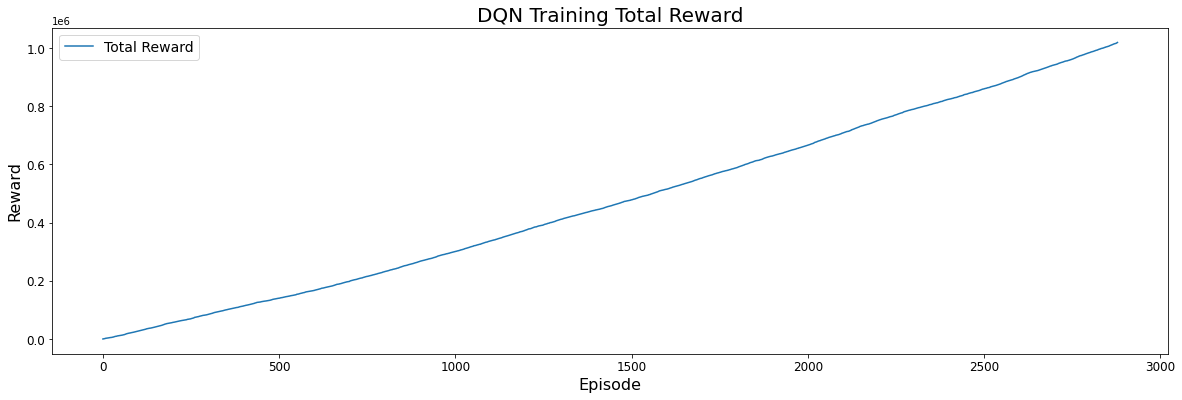

In [15]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, col='Total Reward', x_label='Episode', y_label='Reward', title='DQN Training Total Reward')

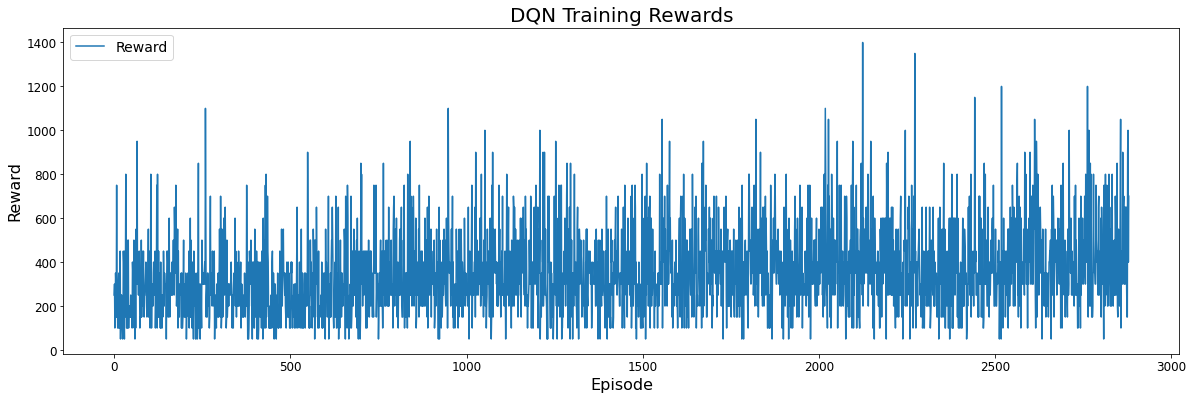

In [16]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, col='Reward', x_label='Episode', y_label='Reward', title='DQN Training Rewards')

In [17]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('sumtree_ddqn_data.csv')

In [18]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
online_model = agent.online
online_model.save('trained_ddqn_online_model.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
target_model = agent.target
target_model.save('trained_ddqn_target_model.h5')  